## Generate Static Graphs

These are the input parameters for the notebook. They will be automatically changed when the scripts to generate monthly statistics are run. You can modify them manually to generate multiple plots locally as well.

Pass in `None` to remove the filters and plot all data. This is not recommended for production settings, but might be useful for reports based on data snapshots.

In [1]:
year = 2021
month = 9
program = "prepilot"
study_type = None

In [2]:
from collections import defaultdict
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import emission.core.get_database as edb
import emission.core.wrapper.entry as ecwe
import emission.storage.decorations.analysis_timeseries_queries as esda
import emission.storage.decorations.trip_queries as esdt
import emission.storage.decorations.timeline as esdl
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
from plots import *
import scaffolding
from uuid import UUID

sns.set_style("whitegrid")
sns.set()
%matplotlib inline

Connecting to database URL db


In [3]:
# Loading mapping dictionaries from mapping_dictionaries notebook
%store -r df_ei
%store -r dic_re
%store -r dic_pur
%store -r dic_fuel

# convert a dictionary to a defaultdict
dic_re = defaultdict(lambda: 'Other',dic_re)
dic_pur = defaultdict(lambda: 'Other',dic_pur)
dic_fuel = defaultdict(lambda: 'Other',dic_fuel)

## Collect Data From Database

In [4]:
tq = scaffolding.get_time_query(year, month)
participant_ct_df = scaffolding.load_all_participant_trips(program, tq)
labeled_ct = scaffolding.filter_labeled_trips(participant_ct_df)
expanded_ct = scaffolding.expand_userinputs(labeled_ct)
expanded_ct = scaffolding.data_quality_check(expanded_ct)

[UUID('863e9c6c-8ec0-48c4-b765-3f73d839c85b'),
 UUID('c6e4db31-c18b-4355-b02a-7dd97deca70b'),
 UUID('c6807997-194c-4c52-8a8f-a8c1f6ee1595'),
 UUID('e9e479e9-5c3f-4345-a885-dadb7999b312'),
 UUID('6656c04c-6cba-4c18-9fed-805eaa529741'),
 UUID('9910245f-ee4e-4cca-ab4c-dd2312eb0d5d'),
 UUID('9b5154d6-3f45-4778-9ebc-a8e5e3ff2e98'),
 UUID('509b9093-9093-4e98-8eb1-20b58ed9bd8c'),
 UUID('e192b8a0-0b6c-4222-9685-1c93785deaf7'),
 UUID('2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d'),
 UUID('56e23e21-6152-4f59-9253-50bd28a5d7f9'),
 UUID('840297ae-3948-4e26-bfeb-e83ee30c5b3e'),
 UUID('d7a732f4-a864-4bcb-b8de-dfc8be242fb2'),
 UUID('5ad862e7-9a63-41f6-9f28-c0096fe884da'),
 UUID('21c78a1c-6df2-4097-b289-5a784610991b'),
 UUID('e4cfb2a8-f600-4268-9756-9985e234636e'),
 UUID('fc68a5bb-0a7b-4b63-86b3-f08a69ead36f'),
 UUID('321b7e37-a9a1-4775-9ebb-b5dc88e183fb'),
 UUID('28cb1dde-8551-4bba-bfd4-2145bdaf7e0a'),
 UUID('e35e6510-7a34-496d-b49f-a5a0b41a1e9e'),
 UUID('d3735ba2-12dd-4c76-8e16-75dca7bdcb6f'),
 UUID('97953a

Loaded all confirmed trips of length 11836


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationDistFilter,1.630502e+09,2021-09-01T07:15:17.000028-06:00,"{'type': 'Point', 'coordinates': [-107.8694824...",612f7d247b8bfbc09d1acd26,1.630501e+09,2021-09-01T06:57:24.690419-06:00,"{'type': 'Point', 'coordinates': [-107.8518209...",1072.309608,11851.503432,...,9,1,7,15,17,2,America/Denver,612f7d9d7b8bfbc09d1acd60,c6e4db31-c18b-4355-b02a-7dd97deca70b,1.630502e+09
1,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:52:37.999908-06:00,"{'type': 'Point', 'coordinates': [-107.8689998...",612f8b1fe68d63d2fb8d7a1a,1.630504e+09,2021-09-01T07:40:11.520930-06:00,"{'type': 'Point', 'coordinates': [-107.8835057...",746.478978,3711.798398,...,9,1,7,52,37,2,America/Denver,612f8b64e68d63d2fb8d7a49,5ad862e7-9a63-41f6-9f28-c0096fe884da,1.630506e+09
2,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:49:45.606963-06:00,"{'type': 'Point', 'coordinates': [-107.8600675...",612f8b3786733a8f9a900db7,1.630503e+09,2021-09-01T07:35:10.901781-06:00,"{'type': 'Point', 'coordinates': [-107.8720599...",874.705182,10355.326280,...,9,1,7,49,45,2,America/Denver,612f8b6686733a8f9a900df4,c6807997-194c-4c52-8a8f-a8c1f6ee1595,1.630506e+09
3,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:53:28.001725-06:00,"{'type': 'Point', 'coordinates': [-107.8853829...",612f8b2d5f105b1932cef7a8,1.630504e+09,2021-09-01T07:46:08.299580-06:00,"{'type': 'Point', 'coordinates': [-107.8694824...",439.702145,2127.880652,...,9,1,7,53,28,2,America/Denver,612f8b8f5f105b1932cef7cd,c6e4db31-c18b-4355-b02a-7dd97deca70b,1.630506e+09
4,DwellSegmentationTimeFilter,1.630506e+09,2021-09-01T08:26:33.949000-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",612f99122648c522f963a886,1.630506e+09,2021-09-01T08:13:23.524000-06:00,"{'type': 'Point', 'coordinates': [-107.9060695...",790.425000,6186.329651,...,9,1,8,26,33,2,America/Denver,612f998d2648c522f963a8ba,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630509e+09


After filtering, found 11836 participant trips 


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationDistFilter,1.630502e+09,2021-09-01T07:15:17.000028-06:00,"{'type': 'Point', 'coordinates': [-107.8694824...",612f7d247b8bfbc09d1acd26,1.630501e+09,2021-09-01T06:57:24.690419-06:00,"{'type': 'Point', 'coordinates': [-107.8518209...",1072.309608,11851.503432,...,9,1,7,15,17,2,America/Denver,612f7d9d7b8bfbc09d1acd60,c6e4db31-c18b-4355-b02a-7dd97deca70b,1.630502e+09
1,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:52:37.999908-06:00,"{'type': 'Point', 'coordinates': [-107.8689998...",612f8b1fe68d63d2fb8d7a1a,1.630504e+09,2021-09-01T07:40:11.520930-06:00,"{'type': 'Point', 'coordinates': [-107.8835057...",746.478978,3711.798398,...,9,1,7,52,37,2,America/Denver,612f8b64e68d63d2fb8d7a49,5ad862e7-9a63-41f6-9f28-c0096fe884da,1.630506e+09
2,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:49:45.606963-06:00,"{'type': 'Point', 'coordinates': [-107.8600675...",612f8b3786733a8f9a900db7,1.630503e+09,2021-09-01T07:35:10.901781-06:00,"{'type': 'Point', 'coordinates': [-107.8720599...",874.705182,10355.326280,...,9,1,7,49,45,2,America/Denver,612f8b6686733a8f9a900df4,c6807997-194c-4c52-8a8f-a8c1f6ee1595,1.630506e+09
3,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:53:28.001725-06:00,"{'type': 'Point', 'coordinates': [-107.8853829...",612f8b2d5f105b1932cef7a8,1.630504e+09,2021-09-01T07:46:08.299580-06:00,"{'type': 'Point', 'coordinates': [-107.8694824...",439.702145,2127.880652,...,9,1,7,53,28,2,America/Denver,612f8b8f5f105b1932cef7cd,c6e4db31-c18b-4355-b02a-7dd97deca70b,1.630506e+09
4,DwellSegmentationTimeFilter,1.630506e+09,2021-09-01T08:26:33.949000-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",612f99122648c522f963a886,1.630506e+09,2021-09-01T08:13:23.524000-06:00,"{'type': 'Point', 'coordinates': [-107.9060695...",790.425000,6186.329651,...,9,1,8,26,33,2,America/Denver,612f998d2648c522f963a8ba,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630509e+09


After filtering, found 5458 labeled trips


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
4,DwellSegmentationTimeFilter,1.630506e+09,2021-09-01T08:26:33.949000-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",612f99122648c522f963a886,1.630506e+09,2021-09-01T08:13:23.524000-06:00,"{'type': 'Point', 'coordinates': [-107.9060695...",790.425000,6186.329651,...,9,1,8,26,33,2,America/Denver,612f998d2648c522f963a8ba,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630509e+09
7,DwellSegmentationTimeFilter,1.630512e+09,2021-09-01T10:07:39.824000-06:00,"{'type': 'Point', 'coordinates': [-107.8598234...",612fa723ce8c93ad2e54b60a,1.630511e+09,2021-09-01T09:48:45.703800-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",1134.120200,10998.235798,...,9,1,10,7,39,2,America/Denver,612fa72cce8c93ad2e54b646,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630513e+09
8,DwellSegmentationDistFilter,1.630512e+09,2021-09-01T09:55:54.618285-06:00,"{'type': 'Point', 'coordinates': [-107.8724742...",612fa74132ef04cc63d731fc,1.630510e+09,2021-09-01T09:29:24.795737-06:00,"{'type': 'Point', 'coordinates': [-107.8559166...",1589.822548,5695.277053,...,9,1,9,55,54,2,America/Denver,612fa78b32ef04cc63d73258,d7a732f4-a864-4bcb-b8de-dfc8be242fb2,1.630513e+09
11,DwellSegmentationTimeFilter,1.630514e+09,2021-09-01T10:29:08-06:00,"{'type': 'Point', 'coordinates': [-107.8653703...",612fc32eff291becf892aedd,1.630513e+09,2021-09-01T10:17:37.157156-06:00,"{'type': 'Point', 'coordinates': [-107.8598234...",690.842844,1445.210704,...,9,1,10,29,8,2,America/Denver,612fc331ff291becf892af5c,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630520e+09
12,DwellSegmentationTimeFilter,1.630516e+09,2021-09-01T11:05:06.885000-06:00,"{'type': 'Point', 'coordinates': [-107.8600612...",612fc32eff291becf892aedf,1.630514e+09,2021-09-01T10:32:08-06:00,"{'type': 'Point', 'coordinates': [-107.8653703...",1978.885000,926.533108,...,9,1,11,5,6,2,America/Denver,612fc331ff291becf892af5d,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630520e+09


,mode_confirm,purpose_confirm,replaced_mode
4,drove_alone,home,NaN
7,drove_alone,work,NaN
8,bike,work,bike
11,drove_alone,at_work,NaN
12,drove_alone,work,NaN


After expanding, columns went from 38 -> 41


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,mode_confirm,purpose_confirm,replaced_mode
4,DwellSegmentationTimeFilter,1.630506e+09,2021-09-01T08:26:33.949000-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",612f99122648c522f963a886,1.630506e+09,2021-09-01T08:13:23.524000-06:00,"{'type': 'Point', 'coordinates': [-107.9060695...",790.425000,6186.329651,...,26,33,2,America/Denver,612f998d2648c522f963a8ba,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630509e+09,drove_alone,home,NaN
7,DwellSegmentationTimeFilter,1.630512e+09,2021-09-01T10:07:39.824000-06:00,"{'type': 'Point', 'coordinates': [-107.8598234...",612fa723ce8c93ad2e54b60a,1.630511e+09,2021-09-01T09:48:45.703800-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",1134.120200,10998.235798,...,7,39,2,America/Denver,612fa72cce8c93ad2e54b646,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630513e+09,drove_alone,work,NaN
8,DwellSegmentationDistFilter,1.630512e+09,2021-09-01T09:55:54.618285-06:00,"{'type': 'Point', 'coordinates': [-107.8724742...",612fa74132ef04cc63d731fc,1.630510e+09,2021-09-01T09:29:24.795737-06:00,"{'type': 'Point', 'coordinates': [-107.8559166...",1589.822548,5695.277053,...,55,54,2,America/Denver,612fa78b32ef04cc63d73258,d7a732f4-a864-4bcb-b8de-dfc8be242fb2,1.630513e+09,bike,work,bike
11,DwellSegmentationTimeFilter,1.630514e+09,2021-09-01T10:29:08-06:00,"{'type': 'Point', 'coordinates': [-107.8653703...",612fc32eff291becf892aedd,1.630513e+09,2021-09-01T10:17:37.157156-06:00,"{'type': 'Point', 'coordinates': [-107.8598234...",690.842844,1445.210704,...,29,8,2,America/Denver,612fc331ff291becf892af5c,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630520e+09,drove_alone,at_work,NaN
12,DwellSegmentationTimeFilter,1.630516e+09,2021-09-01T11:05:06.885000-06:00,"{'type': 'Point', 'coordinates': [-107.8600612...",612fc32eff291becf892aedf,1.630514e+09,2021-09-01T10:32:08-06:00,"{'type': 'Point', 'coordinates': [-107.8653703...",1978.885000,926.533108,...,5,6,2,America/Denver,612fc331ff291becf892af5d,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630520e+09,drove_alone,work,NaN


In [5]:
# Mapping new labels with dictionaries
expanded_ct['Trip_purpose']= expanded_ct['purpose_confirm'].map(dic_pur)
expanded_ct['Mode_confirm']= expanded_ct['mode_confirm'].map(dic_re)
expanded_ct['Replaced_mode']= expanded_ct['replaced_mode'].map(dic_re)

# Mapping fuel
expanded_ct['Mode_confirm_fuel']= expanded_ct['Mode_confirm'].map(dic_fuel)
expanded_ct['Replaced_mode_fuel']= expanded_ct['Replaced_mode'].map(dic_fuel)

# Change meters to miles
scaffolding.unit_conversions(expanded_ct)

# Calculate energy impact
expanded_ct = scaffolding.energy_intensity(expanded_ct, df_ei, 'distance_miles', 'Replaced_mode', 'Mode_confirm')
expanded_ct = scaffolding.energy_impact_kWH(expanded_ct, 'distance_miles', 'Replaced_mode', 'Mode_confirm')
expanded_ct = scaffolding.CO2_impact_lb(expanded_ct, 'distance_miles', 'Replaced_mode', 'Mode_confirm')

In [6]:
file_suffix = scaffolding.get_file_suffix(year, month, program)
quality_text = scaffolding.get_quality_text(participant_ct_df, expanded_ct)

_2021_09_prepilot
Based on 5458 confirmed trips from 90 users
of 11836 total trips from 123 users (46.11%)


## Data Preprocessing

In [7]:
# Get timestamp from known year/month/day aggregated to days
data = expanded_ct[['user_id','start_local_dt_year','start_local_dt_month','start_local_dt_day','Mode_confirm','Mode_confirm_EI(kWH)','Mode_confirm_lb_CO2','distance_miles']].copy()
data.rename(columns={'start_local_dt_year':'year','start_local_dt_month':'month','start_local_dt_day':'day'}, inplace=True)
data['date_time'] = pd.to_datetime(data[['year','month','day']])
data = data.drop(columns=['year','month','day'])

# Categorical type will include all days/modes in groupby even if there is no data for a particular tabulation
data.user_id = pd.Categorical(data.user_id)
data.date_time = pd.Categorical(data.date_time)
data.Mode_confirm = pd.Categorical(data.Mode_confirm,
                                   ordered=True,
                                   categories=['Car, drove alone',
                                              'Car, with others',
                                              'Taxi/Uber/Lyft',
                                              'Bus',
                                              'Free Shuttle',
                                              'Train',
                                              'Bikeshare',
                                              'Pilot ebike',
                                              'Regular Bike',
                                              'Scooter share',
                                              'Skate board',
                                              'Walk',
                                              'Other',
                                              'Not a Trip'])

data.head()

,user_id,Mode_confirm,Mode_confirm_EI(kWH),Mode_confirm_lb_CO2,distance_miles,date_time
4,e9e479e9-5c3f-4345-a885-dadb7999b312,"Car, drove alone",5.811499,3.117223,3.835524,2021-09-01
7,e9e479e9-5c3f-4345-a885-dadb7999b312,"Car, drove alone",10.331850,5.541889,6.818906,2021-09-01
8,d7a732f4-a864-4bcb-b8de-dfc8be242fb2,Regular Bike,0.000000,0.000000,3.531072,2021-09-01
11,e9e479e9-5c3f-4345-a885-dadb7999b312,"Car, drove alone",1.357645,0.728226,0.896031,2021-09-01
12,e9e479e9-5c3f-4345-a885-dadb7999b312,"Car, drove alone",0.870394,0.466870,0.574451,2021-09-01


In [8]:
# Count the number of trips for each confirmed mode
mode_counts = data.groupby(['user_id','date_time','Mode_confirm'], as_index=False).size()
mode_counts.rename(columns={'size':'trip_count'}, inplace=True)

# Sum daily distance traveled for each mode
mode_distance = data.groupby(['user_id','date_time','Mode_confirm'], as_index=False)[['distance_miles']].sum()
mode_distance.rename(columns={'sum':'distance_miles'}, inplace=True)
mode_distance['distance_miles'] = mode_distance['distance_miles'].fillna(0)

# Sum daily emissions for each user
emissions = data.groupby(['user_id','date_time'], as_index=False)[['Mode_confirm_lb_CO2', 'distance_miles']].sum()
emissions['Mode_confirm_lb_CO2'] = emissions['Mode_confirm_lb_CO2'].fillna(0)
emissions['distance_miles'] = emissions['Mode_confirm_lb_CO2'].fillna(0)

# Sum daily energy for each user
energy = data.groupby(['user_id','date_time'], as_index=False)[['Mode_confirm_EI(kWH)', 'distance_miles']].sum()
energy['Mode_confirm_EI(kWH)'] = energy['Mode_confirm_EI(kWH)'].fillna(0)
energy['distance_miles'] = energy['Mode_confirm_EI(kWH)'].fillna(0)

# Get the count of unique users that were active on each given date
active_users = pd.DataFrame(data.groupby(['date_time'], as_index=False)['user_id'].nunique())
active_users.rename(columns={'user_id':'active_users'}, inplace=True)

# Add 7-day rolling avg smoothing to better see trends
mode_counts['trip_count_smooth'] = mode_counts.groupby(['user_id','Mode_confirm'])['trip_count'].apply(lambda x: x.rolling(7,1).mean())
mode_distance['distance_miles_smooth'] = mode_distance.groupby(['user_id','Mode_confirm'])['distance_miles'].apply(lambda x: x.rolling(7,1).mean())
emissions['distance_miles_smooth'] = emissions.groupby(['user_id'])['distance_miles'].apply(lambda x: x.rolling(7,1).mean())
energy['distance_miles_smooth'] = energy.groupby(['user_id'])['distance_miles'].apply(lambda x: x.rolling(7,1).mean())

### Generate Timeseries Plots

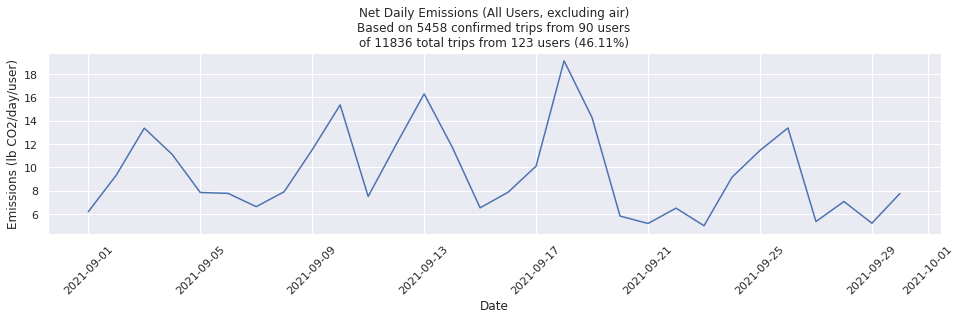

In [9]:
# Emissions per week across all users (net impact)
plot_data = emissions.groupby(['date_time'], as_index=False)['Mode_confirm_lb_CO2'].agg(['sum'])
plot_data = plot_data.merge(active_users, on='date_time')
plot_data['sum'] = plot_data['sum'] / plot_data['active_users']

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='sum').set(title='Net Daily Emissions (All Users, excluding air)\n%s'%quality_text, xlabel='Date', ylabel='Emissions (lb CO2/day/user)')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_emissions_user%s.png"%file_suffix, bbox_inches='tight')

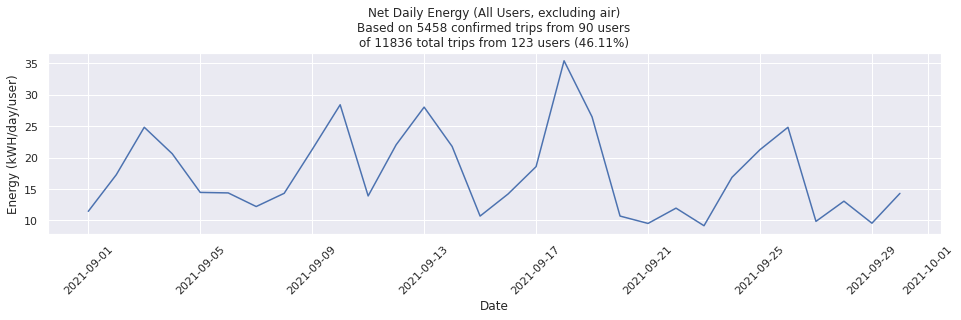

In [10]:
# Energy per week across all users (net impact)
plot_data = energy.groupby(['date_time'], as_index=False)['Mode_confirm_EI(kWH)'].agg(['sum'])
plot_data = plot_data.merge(active_users, on='date_time')
plot_data['sum'] = plot_data['sum'] / plot_data['active_users']

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='sum').set(title='Net Daily Energy (All Users, excluding air)\n%s'%quality_text, xlabel='Date', ylabel='Energy (kWH/day/user)')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_energy_user%s.png"%file_suffix, bbox_inches='tight')

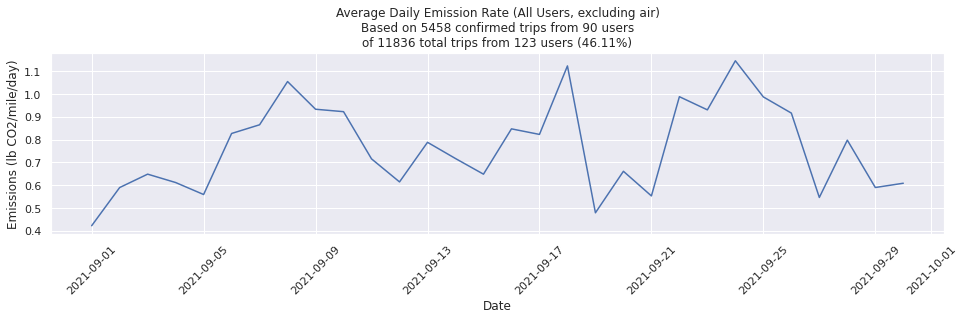

In [11]:
# Emissions per mile per day across all users (travel efficiency)
# Note that the energy plot will be identical to this one since scale factor is divided out
emissions['CO2_per_mile'] = emissions['Mode_confirm_lb_CO2'] / emissions['distance_miles_smooth']
emissions['CO2_per_mile'] = emissions['CO2_per_mile'].fillna(0)
plot_data = emissions.groupby(['date_time'], as_index=False)['CO2_per_mile'].agg(['mean'])

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='mean').set(title='Average Daily Emission Rate (All Users, excluding air)\n%s'%quality_text, xlabel='Date', ylabel='Emissions (lb CO2/mile/day)')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_emissions_vmt%s.png"%file_suffix, bbox_inches='tight')

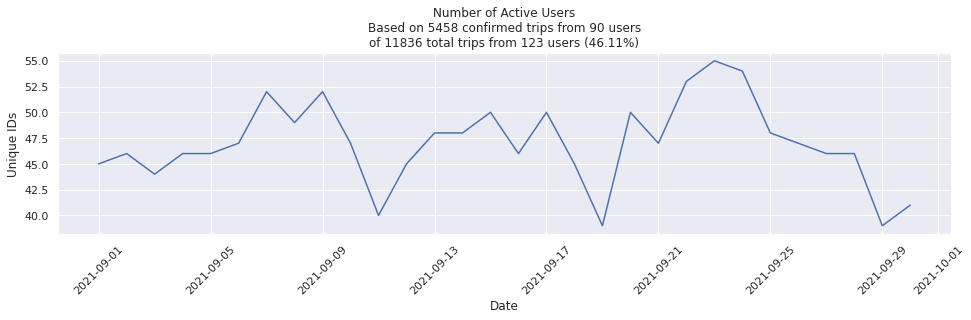

In [12]:
# Plot of active users
plot_data = active_users

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='active_users').set(title='Number of Active Users\n%s'%quality_text, xlabel='Date', ylabel='Unique IDs')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_users%s.png"%file_suffix, bbox_inches='tight')

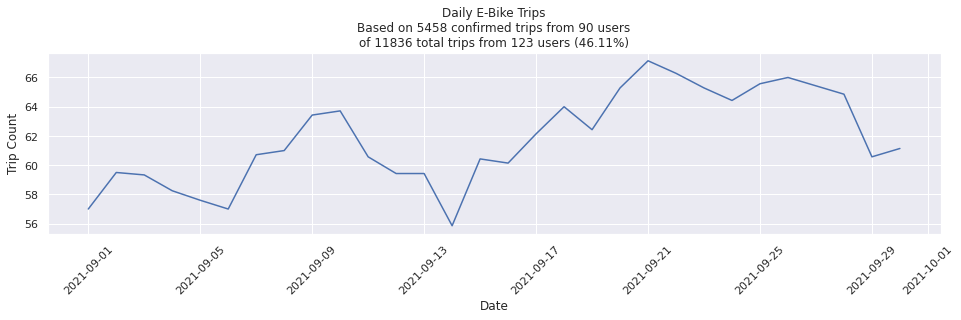

In [13]:
# Plot of total ebikeshare trips across all users
plot_data = mode_counts[mode_counts['Mode_confirm']=='Pilot ebike']
plot_data = plot_data.groupby(['date_time'], as_index=False)['trip_count_smooth'].agg(['sum'])

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='sum').set(title='Daily E-Bike Trips\n%s'%quality_text, xlabel='Date', ylabel='Trip Count')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_ebike_share%s.png"%file_suffix, bbox_inches='tight')

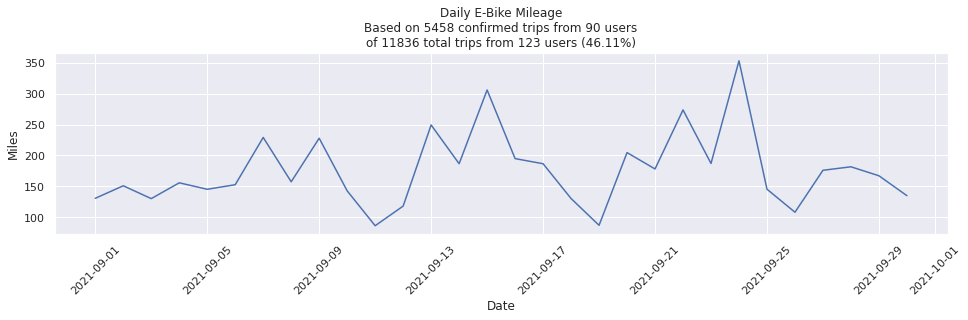

In [14]:
# Plot of total ebikeshare mileage across all users
plot_data = data[data['Mode_confirm']=='Pilot ebike']
plot_data = plot_data.groupby(['date_time'], as_index=False)['distance_miles'].agg(['sum'])

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='sum').set(title='Daily E-Bike Mileage\n%s'%quality_text, xlabel='Date', ylabel='Miles')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_ebike_miles%s.png"%file_suffix, bbox_inches='tight')

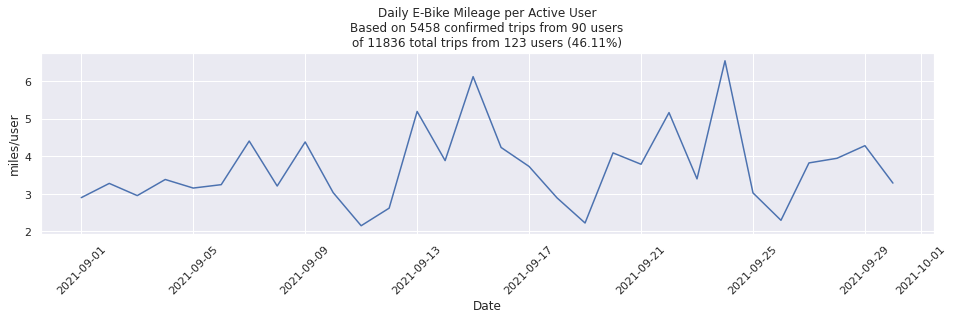

In [15]:
# Plot of total ebikeshare mileage normalized by number of users
plot_data = data[data['Mode_confirm']=='Pilot ebike']
plot_data = plot_data.groupby(['date_time'], as_index=False)['distance_miles'].agg(['sum'])
plot_data = plot_data.merge(active_users, on='date_time')
plot_data['mileage_per_user'] = plot_data['sum'] / plot_data['active_users']

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='mileage_per_user').set(title='Daily E-Bike Mileage per Active User\n%s'%quality_text, xlabel='Date', ylabel='miles/user')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_ebike_miles_user%s.png"%file_suffix, bbox_inches='tight')

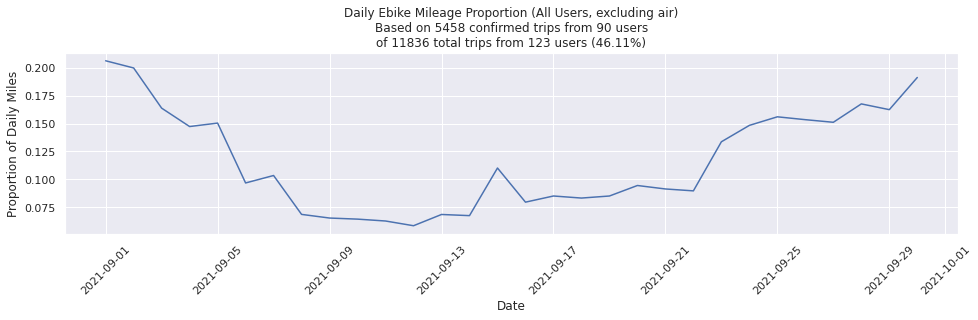

In [16]:
# Plot of ebike mileage share proportion across all users
plot_data = mode_distance[mode_distance['Mode_confirm']=='Pilot ebike']
plot_data = plot_data.groupby(['date_time'], as_index=False)['distance_miles_smooth'].sum()
total_miles = mode_distance.groupby(['date_time'], as_index=False)['distance_miles_smooth'].sum()
plot_data = plot_data.merge(total_miles, on=['date_time'])
plot_data['miles_proportion'] = plot_data['distance_miles_smooth_x'] / plot_data['distance_miles_smooth_y']

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='miles_proportion', legend=False, palette="Set1").set(title='Daily Ebike Mileage Proportion (All Users, excluding air)\n%s'%quality_text, xlabel='Date', ylabel='Proportion of Daily Miles')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)


ax.figure.savefig("/plots/ts_ebike_miles_proportion%s.png"%file_suffix, bbox_inches='tight')

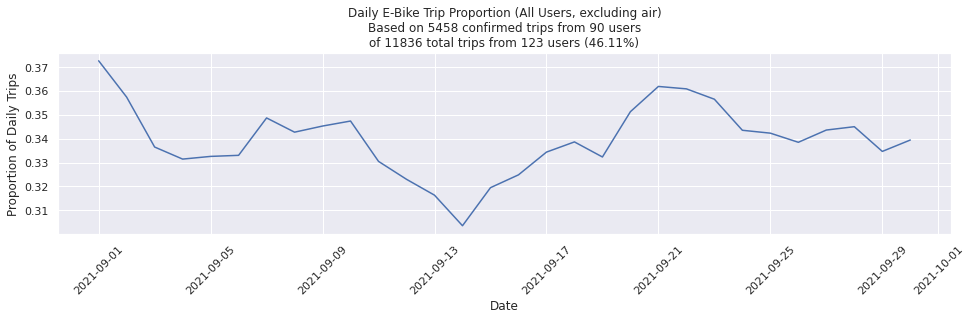

In [17]:
# Plot of ebike trip share proportion across all users
plot_data = mode_counts.groupby(['date_time','Mode_confirm'], as_index=False)['trip_count_smooth'].sum()
total_trips = plot_data.groupby(['date_time'], as_index=False).sum()
plot_data = plot_data.merge(total_trips, on='date_time')
plot_data['trip_proportion'] = plot_data['trip_count_smooth_x'] / plot_data['trip_count_smooth_y']
plot_data = plot_data[plot_data['Mode_confirm']=='Pilot ebike']

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='trip_proportion').set(title='Daily E-Bike Trip Proportion (All Users, excluding air)\n%s'%quality_text, xlabel='Date', ylabel='Proportion of Daily Trips')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_ebike_trips_proportion%s.png"%file_suffix, bbox_inches='tight')

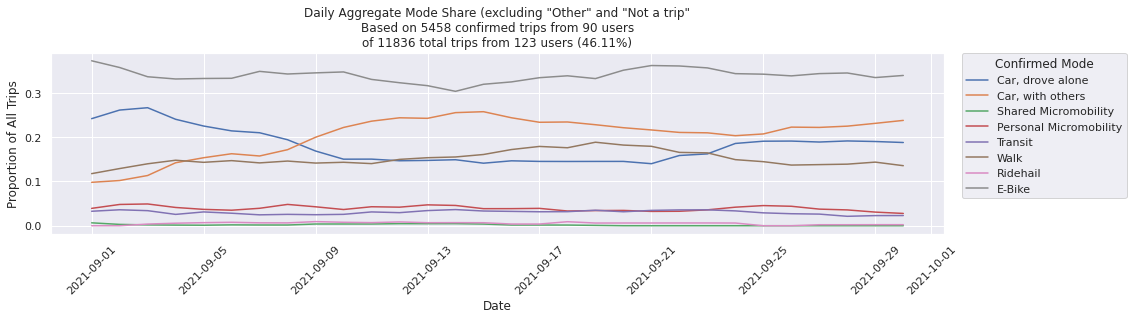

In [18]:
# Plot of mode share proportions across all users
# Consolidate modes
plot_data = mode_counts.replace('Bikeshare', 'Shared Micromobility')
plot_data = plot_data.replace('Scooter share', 'Shared Micromobility')
plot_data = plot_data.replace('Regular Bike', 'Personal Micromobility')
plot_data = plot_data.replace('Skate board', 'Personal Micromobility')
plot_data = plot_data.replace('Train', 'Transit')
plot_data = plot_data.replace('Free Shuttle', 'Transit')
plot_data = plot_data.replace('Bus', 'Transit')
plot_data = plot_data.replace('Walk', 'Walk')
plot_data = plot_data.replace('Taxi/Uber/Lyft', 'Ridehail')
plot_data = plot_data.replace('Pilot ebike', 'E-Bike')

plot_data = plot_data.groupby(['date_time','Mode_confirm'], as_index=False)['trip_count_smooth'].sum()
total_trips = plot_data.groupby(['date_time'], as_index=False).sum()
plot_data = plot_data.merge(total_trips, on='date_time')
plot_data['trip_proportion'] = plot_data['trip_count_smooth_x'] / plot_data['trip_count_smooth_y']

# Re-establish categorical variable to not include Other and Non-trips
plot_data = plot_data[~plot_data['Mode_confirm'].isin(['Not a Trip','Other'])]
plot_data.Mode_confirm = pd.Categorical(plot_data.Mode_confirm,
                                   categories=['Car, drove alone',
                                              'Car, with others',
                                              'Shared Micromobility',
                                              'Personal Micromobility',
                                              'Transit',
                                              'Walk',
                                              'Ridehail',
                                              'E-Bike'])

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='trip_proportion', hue='Mode_confirm').set(title='Daily Aggregate Mode Share (excluding "Other" and "Not a trip"\n%s'%quality_text, xlabel='Date', ylabel='Proportion of All Trips')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
plt.legend(bbox_to_anchor=(1.02, 1), loc='best', borderaxespad=0, title='Confirmed Mode')
ax.figure.savefig("/plots/ts_all_modes%s.png"%file_suffix, bbox_inches='tight')

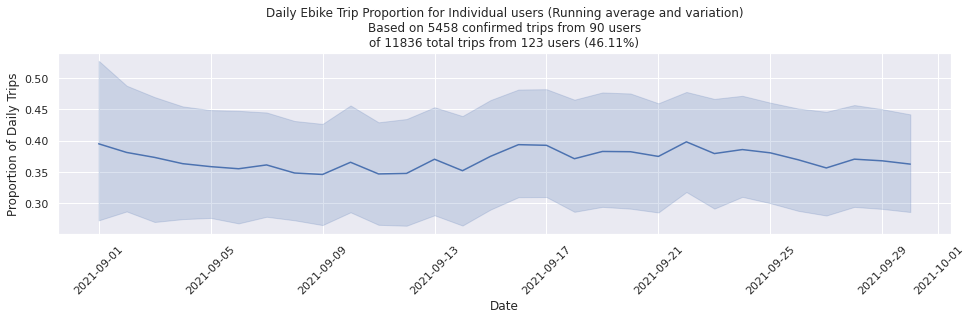

In [19]:
# Plots the number of trips per user with error bars
# from the seaborn documentation:
# By default, the plot aggregates over multiple y values at each value of x and 
# shows an estimate of the central tendency and a confidence interval for that estimate.
# In our case, we have multiple trip proportions (one per user) for each day
# so the band represents the variation of the number of trips and the thick line represents the mean/median (unsure which)
# but this still doesn't tell us which users have dropped their ridership

plot_data = mode_counts

plot_data_ebike = plot_data[plot_data.Mode_confirm == "Pilot ebike"].groupby(['date_time', 'user_id'], as_index=False)["trip_count_smooth"].sum()
# plot_data_ebike[plot_data_ebike.trip_count_smooth != 0]
plot_data = plot_data.groupby(['date_time','user_id'], as_index=False)['trip_count_smooth'].sum()
# plot_data[plot_data.trip_count_smooth != 0]
plot_data = plot_data.merge(plot_data_ebike, on=['date_time', 'user_id'])
# plot_data.loc[24]
plot_data['bike_trip_proportion'] = plot_data['trip_count_smooth_y'] / plot_data['trip_count_smooth_x']
# plot_data.dropna()

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='bike_trip_proportion', legend=False).set(title='Daily Ebike Trip Proportion for Individual users (Running average and variation)\n%s'%quality_text, xlabel='Date', ylabel='Proportion of Daily Trips')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_ebike_trip_individual_variation%s.png"%file_suffix, bbox_inches='tight')

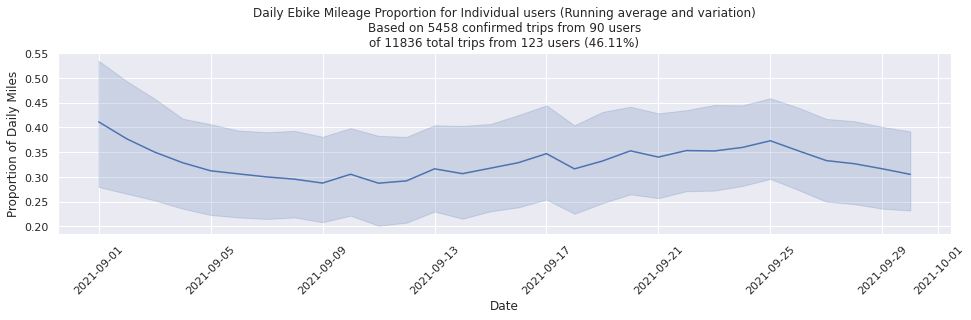

In [20]:
# Plots the number of trips per user with error bars
# from the seaborn documentation:
# By default, the plot aggregates over multiple y values at each value of x and 
# shows an estimate of the central tendency and a confidence interval for that estimate.
# In our case, we have multiple trip proportions (one per user) for each day
# so the band represents the variation of the number of trips and the thick line represents the mean/median (unsure which)
# but this still doesn't tell us which users have dropped their ridership

plot_data = mode_distance

plot_data_ebike = plot_data[plot_data.Mode_confirm == "Pilot ebike"].groupby(['date_time', 'user_id'], as_index=False)["distance_miles_smooth"].sum()
# plot_data_ebike[plot_data_ebike.trip_count_smooth != 0]
plot_data = plot_data.groupby(['date_time','user_id'], as_index=False)['distance_miles_smooth'].sum()
# plot_data[plot_data.trip_count_smooth != 0]
plot_data = plot_data.merge(plot_data_ebike, on=['date_time', 'user_id'])
# plot_data.loc[24]
plot_data['bike_miles_proportion'] = plot_data['distance_miles_smooth_y'] / plot_data['distance_miles_smooth_x']
# plot_data.dropna()

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='bike_miles_proportion', legend=False).set(title='Daily Ebike Mileage Proportion for Individual users (Running average and variation)\n%s'%quality_text, xlabel='Date', ylabel='Proportion of Daily Miles')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_ebike_mile_individual_variation%s.png"%file_suffix, bbox_inches='tight')

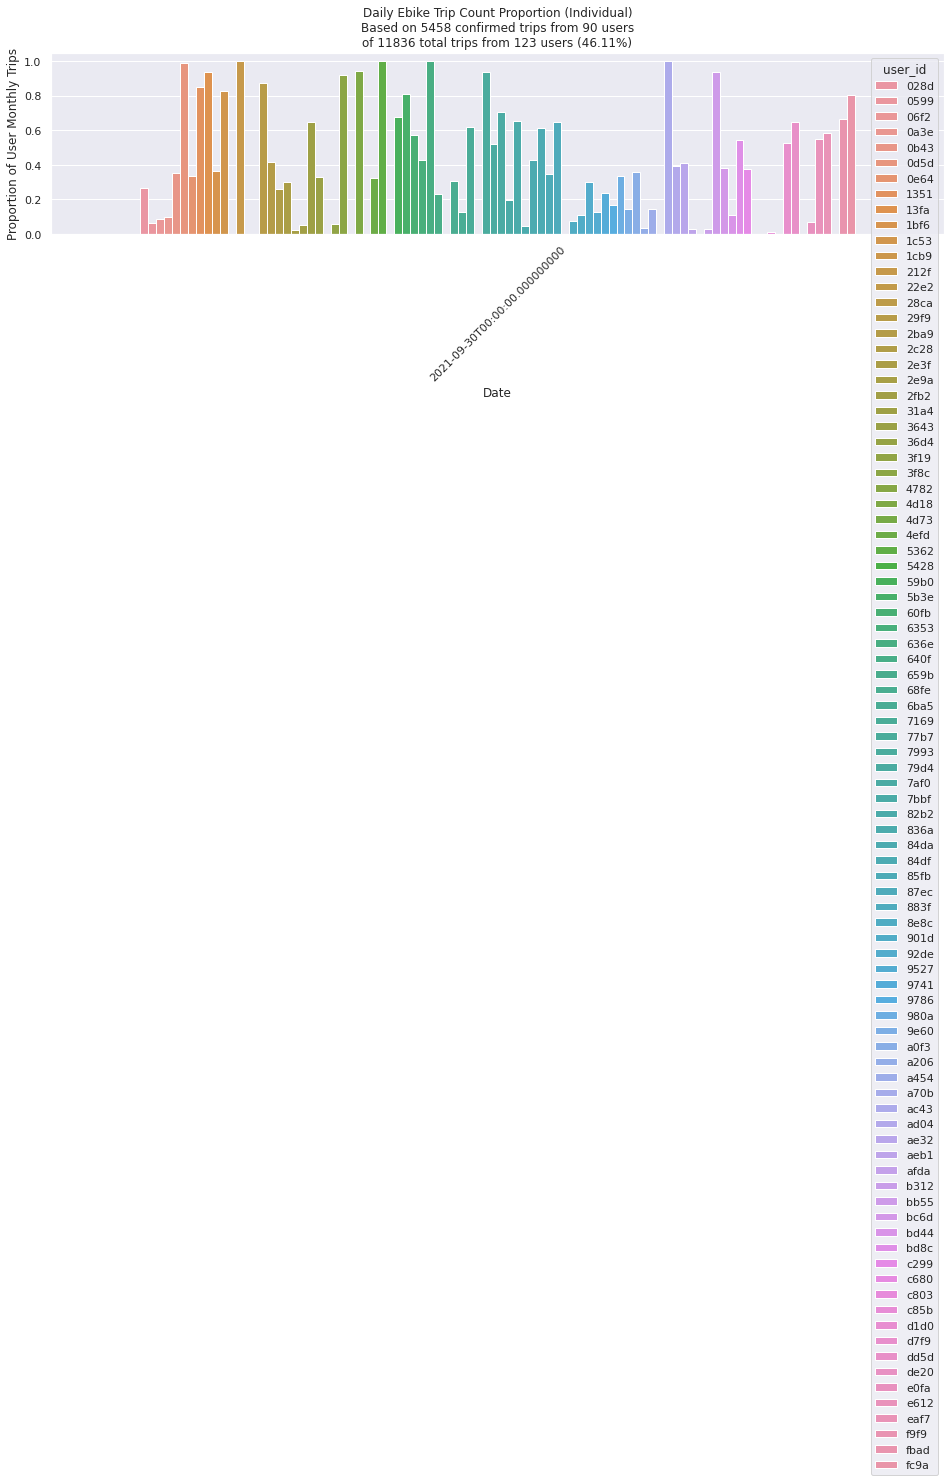

In [21]:
# Plot of ebike mode share across many individual users
# Add weekly grouping to smooth out variation between points
# This explores plotting as bar plots
# Plotting this on a daily basis can get too fine-grained so we try grouping by month

plot_data = mode_counts

plot_data_ebike = plot_data[plot_data.Mode_confirm == "Pilot ebike"].groupby(['date_time', 'user_id'], as_index=False)["trip_count_smooth"].sum()
# plot_data_ebike[plot_data_ebike.trip_count_smooth != 0]
plot_data = plot_data.groupby(['date_time','user_id'], as_index=False)['trip_count_smooth'].sum()
# plot_data[plot_data.trip_count_smooth != 0]
plot_data = plot_data.merge(plot_data_ebike, on=['date_time', 'user_id'])
# plot_data.loc[24]
plot_data['user_id'] = plot_data['user_id'].astype(str).str[-4:]
plot_data['date_time'] = pd.DatetimeIndex(plot_data.date_time)
month_groups = plot_data.groupby(pd.Grouper(freq='M', key="date_time"))
plot_data = pd.DataFrame()
for k, month_df in month_groups:
    month_user_counts = month_df.groupby("user_id").sum()
    month_user_counts["ebike_trip_proportion"] = month_user_counts.trip_count_smooth_y / month_user_counts.trip_count_smooth_x
    month_user_counts["date_month"] = [k] * len(month_user_counts)
    month_user_counts["user_id"] = month_user_counts.index
    plot_data = plot_data.append(month_user_counts)
    
# plot_data
plot_data.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(16,4))
sns.barplot(ax=ax, data=plot_data, x='date_month', y='ebike_trip_proportion', hue="user_id").set(title='Daily Ebike Trip Count Proportion (Individual)\n%s'%quality_text, xlabel='Date', ylabel='Proportion of User Monthly Trips')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
# ax.figure.savefig("/plots/ts_ebike_trip_individual%s.png"%file_suffix, bbox_inches='tight')

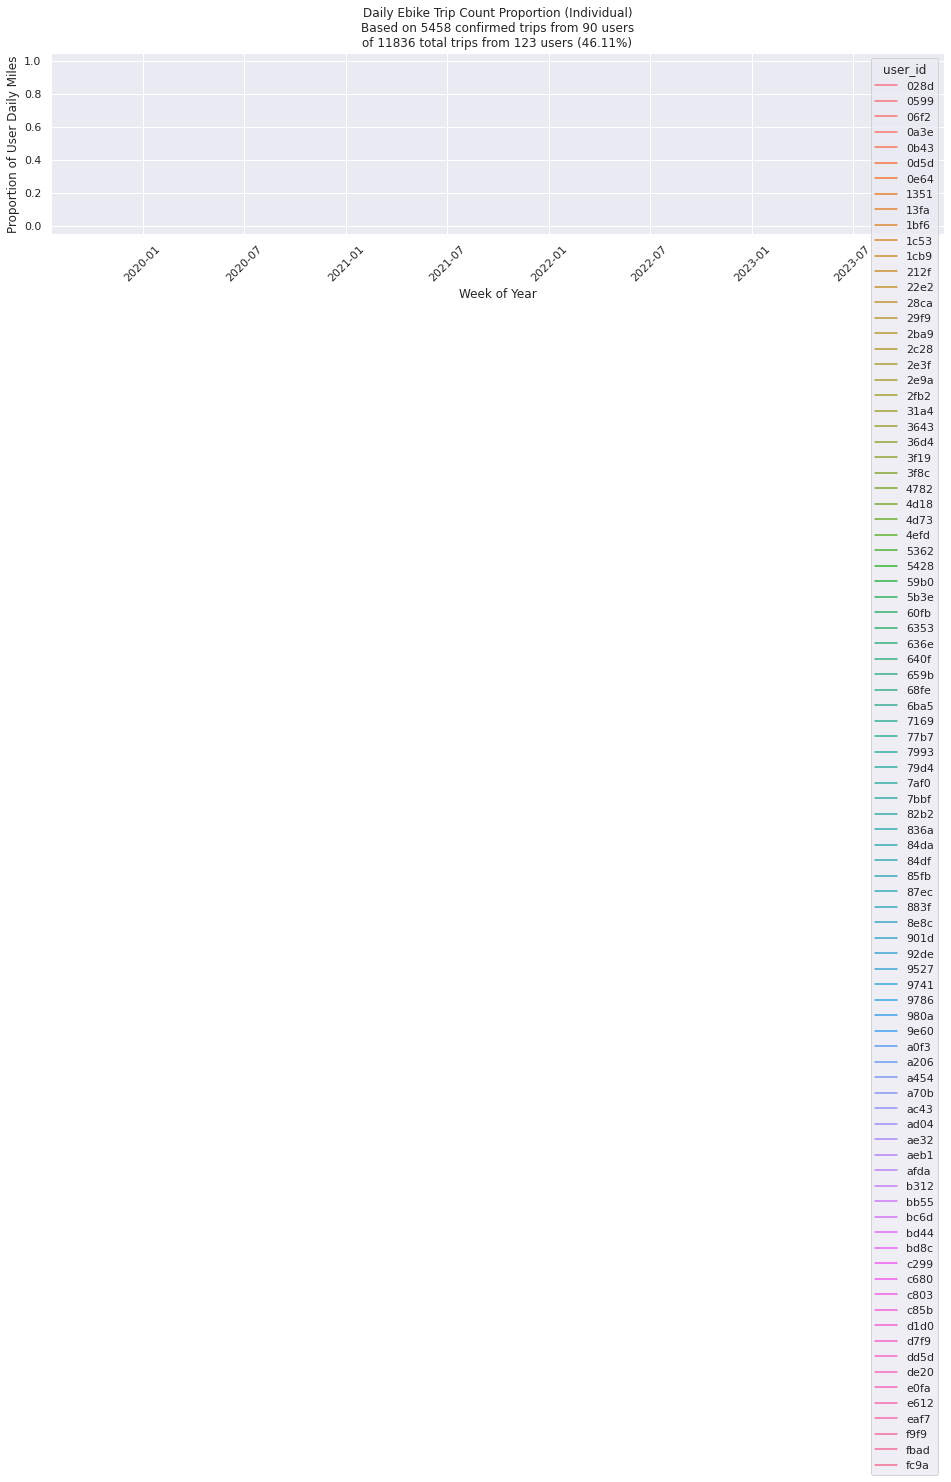

In [22]:
# This explores plotting the same data as a line plot
fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_month', y='ebike_trip_proportion', hue="user_id").set(title='Daily Ebike Trip Count Proportion (Individual)\n%s'%quality_text, xlabel='Week of Year', ylabel='Proportion of User Daily Miles')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)

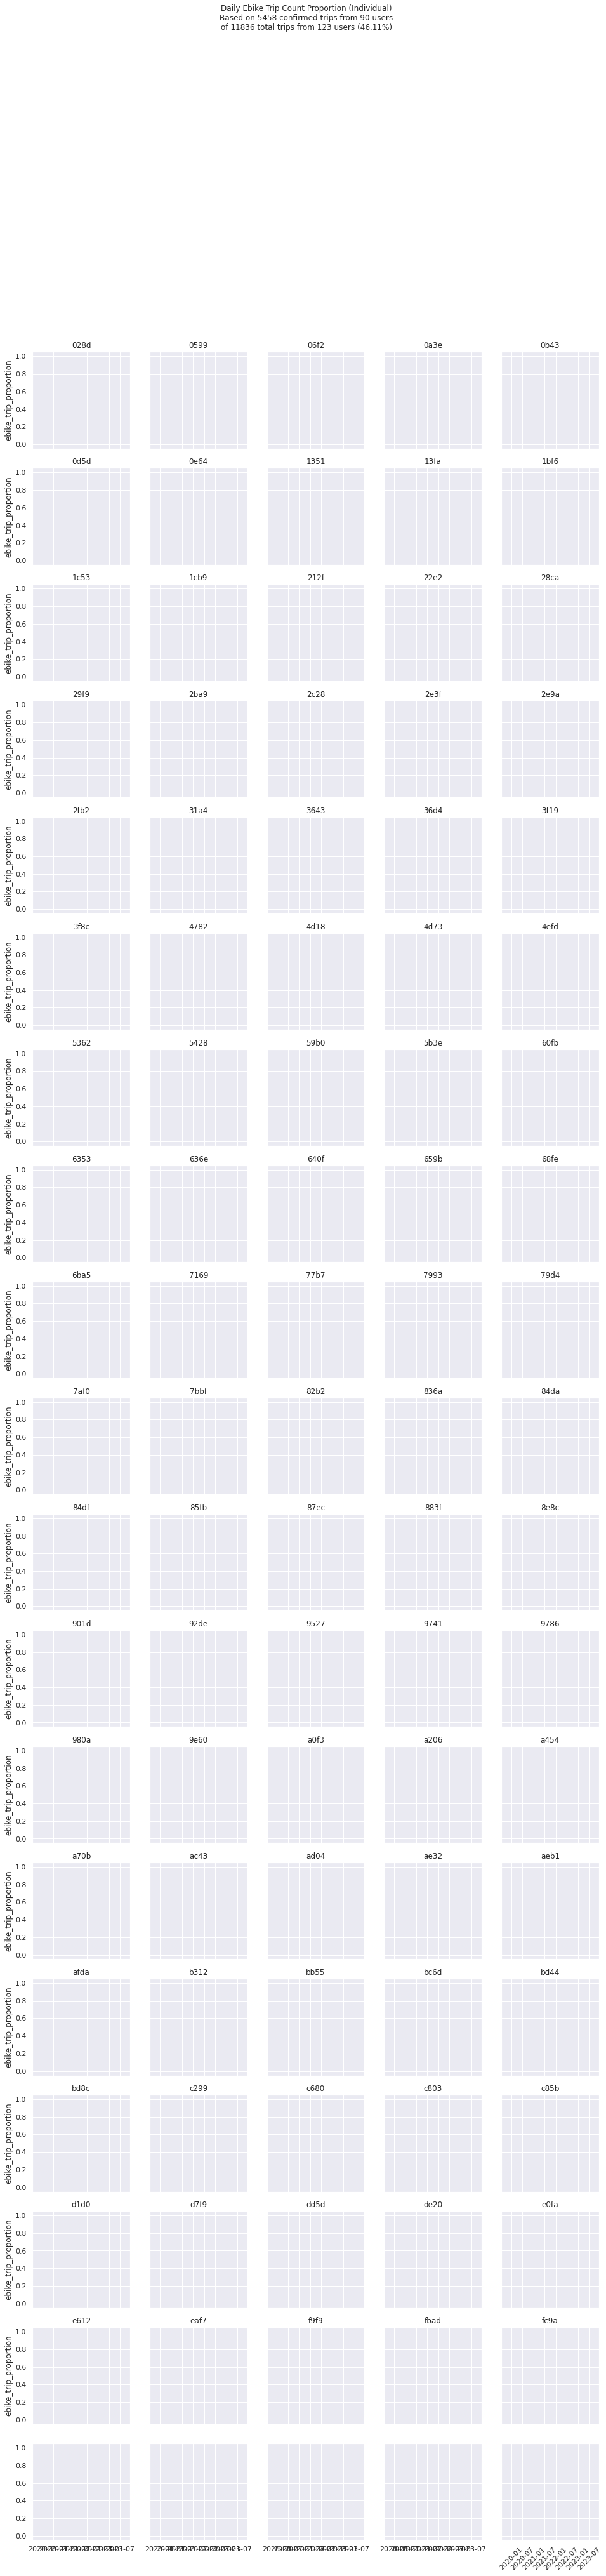

In [23]:
# Plot of ebike mode share across many individual users
# Add weekly grouping to smooth out variation between points
# Both the bar plot and the line plot above are confusing, so we will try plotting subplots instead

plot_data = mode_counts

plot_data_ebike = plot_data[plot_data.Mode_confirm == "Pilot ebike"].groupby(['date_time', 'user_id'], as_index=False)["trip_count_smooth"].sum()
# plot_data_ebike[plot_data_ebike.trip_count_smooth != 0]
plot_data = plot_data.groupby(['date_time','user_id'], as_index=False)['trip_count_smooth'].sum()
# plot_data[plot_data.trip_count_smooth != 0]
plot_data = plot_data.merge(plot_data_ebike, on=['date_time', 'user_id'])
# plot_data.loc[24]
plot_data['user_id'] = plot_data['user_id'].astype(str).str[-4:]
plot_data['date_time'] = pd.DatetimeIndex(plot_data.date_time)
unique_user_ids = plot_data.user_id.unique()
row_count=len(unique_user_ids)//5 + 1
fig, ax_arr = plt.subplots(ncols=5, nrows=row_count, figsize=(16,4*row_count),sharex=True,sharey=True)
flattened_ax_arr = list(itertools.chain.from_iterable(ax_arr))
for i, (user_id, user_df) in enumerate(plot_data.groupby("user_id")):
    month_count_df = user_df.groupby(pd.Grouper(freq='M', key="date_time")).sum()
    # print(month_count_df)
    month_count_df["ebike_trip_proportion"] = month_count_df.trip_count_smooth_y / month_count_df.trip_count_smooth_x
    # print(month_count_df)
    sns.lineplot(ax=flattened_ax_arr[i],data=month_count_df.ebike_trip_proportion).set(title=user_id)
    flattened_ax_arr[i].tick_params(axis='x', rotation=45)

plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
fig.suptitle('Daily Ebike Trip Count Proportion (Individual)\n%s'%quality_text)
fig.savefig("/plots/ts_ebike_trip_proportion_individual%s.png"%file_suffix, bbox_inches='tight')

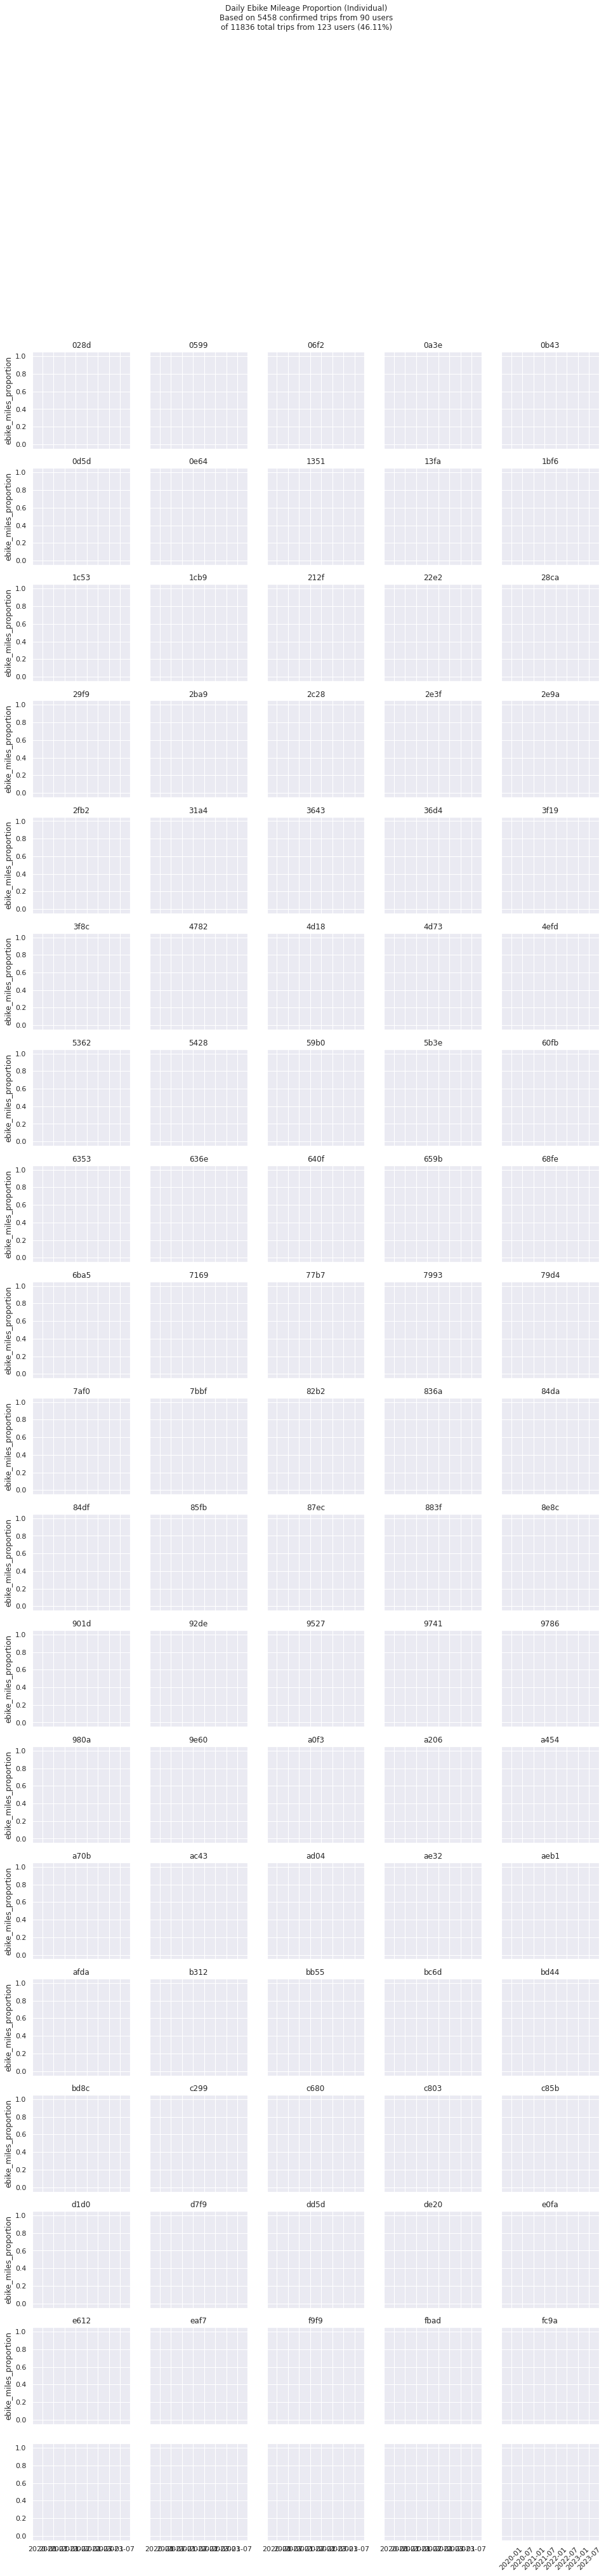

In [24]:
# Plot of ebike mode share across many individual users
# Add weekly grouping to smooth out variation between points
# Both the bar plot and the line plot above are confusing, so we will try plotting subplots instead

plot_data = mode_distance

plot_data_ebike = plot_data[plot_data.Mode_confirm == "Pilot ebike"].groupby(['date_time', 'user_id'], as_index=False)["distance_miles_smooth"].sum()
# plot_data_ebike[plot_data_ebike.trip_count_smooth != 0]
plot_data = plot_data.groupby(['date_time','user_id'], as_index=False)['distance_miles_smooth'].sum()
# plot_data[plot_data.trip_count_smooth != 0]
plot_data = plot_data.merge(plot_data_ebike, on=['date_time', 'user_id'])
# plot_data.loc[24]
plot_data['user_id'] = plot_data['user_id'].astype(str).str[-4:]
plot_data['date_time'] = pd.DatetimeIndex(plot_data.date_time)
unique_user_ids = plot_data.user_id.unique()
row_count=len(unique_user_ids)//5 + 1
fig, ax_arr = plt.subplots(ncols=5, nrows=row_count, figsize=(16,4*row_count),sharex=True,sharey=True)
flattened_ax_arr = list(itertools.chain.from_iterable(ax_arr))
for i, (user_id, user_df) in enumerate(plot_data.groupby("user_id")):
    month_count_df = user_df.groupby(pd.Grouper(freq='M', key="date_time")).sum()
    # print(month_count_df)
    month_count_df["ebike_miles_proportion"] = month_count_df.distance_miles_smooth_y / month_count_df.distance_miles_smooth_x
    # print(month_count_df)
    sns.lineplot(ax=flattened_ax_arr[i],data=month_count_df.ebike_miles_proportion).set(title=user_id)
    flattened_ax_arr[i].tick_params(axis='x', rotation=45)

plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
fig.suptitle('Daily Ebike Mileage Proportion (Individual)\n%s'%quality_text)
fig.savefig("/plots/ts_ebike_mile_proportion_individual%s.png"%file_suffix, bbox_inches='tight')